In [1]:
import os
import sys
sys.path.insert(0, "../utils")
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torchvision

from torch.utils.tensorboard import SummaryWriter
import shutil

plt.style.use('seaborn')
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


import helpers as h
import utils.utils as utils
import utils.visualizations as vis
import utils.cityscapes_loader as cityscapes_loader
import utils.train_eval as train_eval
from utils.train_eval import get_criterion
from utils.models import ResNetUNet


%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/user/sheludzk/anaconda3/envs/CudaLab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
dataset_root_dir = "/home/nfs/inf6/data/datasets/cityscapes/"

train_ds = cityscapes_loader.cityscapesLoader(root=dataset_root_dir, split='train', is_transform=True, img_size=(512, 1024), use_default_aug=True)
val_ds = cityscapes_loader.cityscapesLoader(root=dataset_root_dir, split='val', img_size=(1024, 2048), is_transform=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=3, shuffle=True, num_workers=4, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=3, shuffle=False, num_workers=4, drop_last=True)


Found 2975 train images
Found 500 val images


In [20]:

def show_samples_with_ground_truth(data_loader, n=8):
    fig, ax = plt.subplots(n, 2, figsize=(20,40))
    for i in range(n):
        img, lbl = data_loader.dataset[i]
        img = img.permute(1, 2, 0).numpy()
        lbl = lbl[0].numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
       
        ax[i, 0].imshow(img)
        ground_truth = lbl
        ground_truth = data_loader.dataset.decode_segmap(ground_truth)
        ax[i, 1].imshow(ground_truth)
    plt.show()

#show_samples_with_ground_truth(train_loader, 8)

In [11]:
from typing import Dict
import torch
import torch.nn as nn
import torch.nn.functional as F


# the following code is heavily inspired by  https://github.com/1914669687/ConvUNeXt/blob/master/src/ConvUNeXt.py

class Conv(nn.Module):
    def __init__(self, dim):
        super(Conv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, stride=1, groups=dim, padding_mode='reflect') # depthwise conv
        self.norm1 = nn.BatchNorm2d(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act1 = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.norm2 = nn.BatchNorm2d(dim)
        self.act2 = nn.GELU()
    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = self.norm1(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.pwconv1(x)
        x = self.act1(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        x = self.norm2(x)
        x = self.act2(residual + x)

        return x


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels, layer_num=1):
        layers = nn.ModuleList()
        for i in range(layer_num):
            layers.append(Conv(out_channels))
        super(Down, self).__init__(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2),
            *layers
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True, layer_num=1):
        super(Up, self).__init__()
        C = in_channels // 2
        self.norm = nn.BatchNorm2d(C)
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.gate = nn.Linear(C, 3 * C)
        self.linear1 = nn.Linear(C, C)
        self.linear2 = nn.Linear(C, C)
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        layers = nn.ModuleList()
        for i in range(layer_num):
            layers.append(Conv(out_channels))
        self.conv = nn.Sequential(*layers)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.norm(x1)
        x1 = self.up(x1)
        # [N, C, H, W]
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        # padding_left, padding_right, padding_top, padding_bottom
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])
        #attention
        B, C, H, W = x1.shape
        x1 = x1.permute(0, 2, 3, 1)
        x2 = x2.permute(0, 2, 3, 1)
        gate = self.gate(x1).reshape(B, H, W, 3, C).permute(3, 0, 1, 2, 4)
        g1, g2, g3 = gate[0], gate[1], gate[2]
        x2 = torch.sigmoid(self.linear1(g1 + x2)) * x2 + torch.sigmoid(g2) * torch.tanh(g3)
        x2 = self.linear2(x2)
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)

        x = self.conv1x1(torch.cat([x2, x1], dim=1))
        x = self.conv(x)
        return x


class OutConv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(OutConv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )


class ConvUNeXt(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 num_classes: int = 2,
                 bilinear: bool = True,
                 base_c: int = 32):
        super(ConvUNeXt, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.in_conv = nn.Sequential(
            nn.Conv2d(in_channels, base_c, kernel_size=7, padding=3, padding_mode='reflect'),
            nn.BatchNorm2d(base_c),
            nn.GELU(),
            Conv(base_c)
        )
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8, layer_num=3)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c * 8, base_c * 16 // factor)
        self.up1 = Up(base_c * 16, base_c * 8 // factor, bilinear)
        self.up2 = Up(base_c * 8, base_c * 4 // factor, bilinear)
        self.up3 = Up(base_c * 4, base_c * 2 // factor, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.out_conv = OutConv(base_c, num_classes)

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.out_conv(x)
        return logits
        # return logits

In [12]:
model = ConvUNeXt(in_channels=3, num_classes=19, base_c=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

# criterion_model = get_criterion(loss_type="focal", focal_gamma=0.8)
criterion = get_criterion(loss_type="dice")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=10)

In [5]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs/convunext", utils.timestamp())
utils.create_dir(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

In [1]:
# train_eval.train_model(model, optimizer, scheduler, criterion, train_loader, val_loader,
#                 num_epochs=60, tboard=None, start_epoch=0, device="cuda", writer=writer, copy_blob=True, cut_mix=True, model_name="convunext")


In [13]:
utils.load_model(model, optimizer=optimizer, savepath="./checkpoints_convunext/checkpoint_epoch_59.pth")

(ConvUNeXt(
   (in_conv): Sequential(
     (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): GELU(approximate='none')
     (3): Conv(
       (dwconv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=32, padding_mode=reflect)
       (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (pwconv1): Linear(in_features=32, out_features=128, bias=True)
       (act1): GELU(approximate='none')
       (pwconv2): Linear(in_features=128, out_features=32, bias=True)
       (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (act2): GELU(approximate='none')
     )
   )
   (down1): Down(
     (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (1): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
     (2): Conv(


preds.shape torch.Size([3, 1024, 2048])
image.shape torch.Size([3, 3, 1024, 2048])
label.shape torch.Size([3, 1, 1024, 2048])


/home/user/sheludzk/cudaLab/Assignment_8/utils/visualizations.py:297: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a.set_yticks([], [])
/home/user/sheludzk/cudaLab/Assignment_8/utils/visualizations.py:298: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  a.set_xticks([], [])


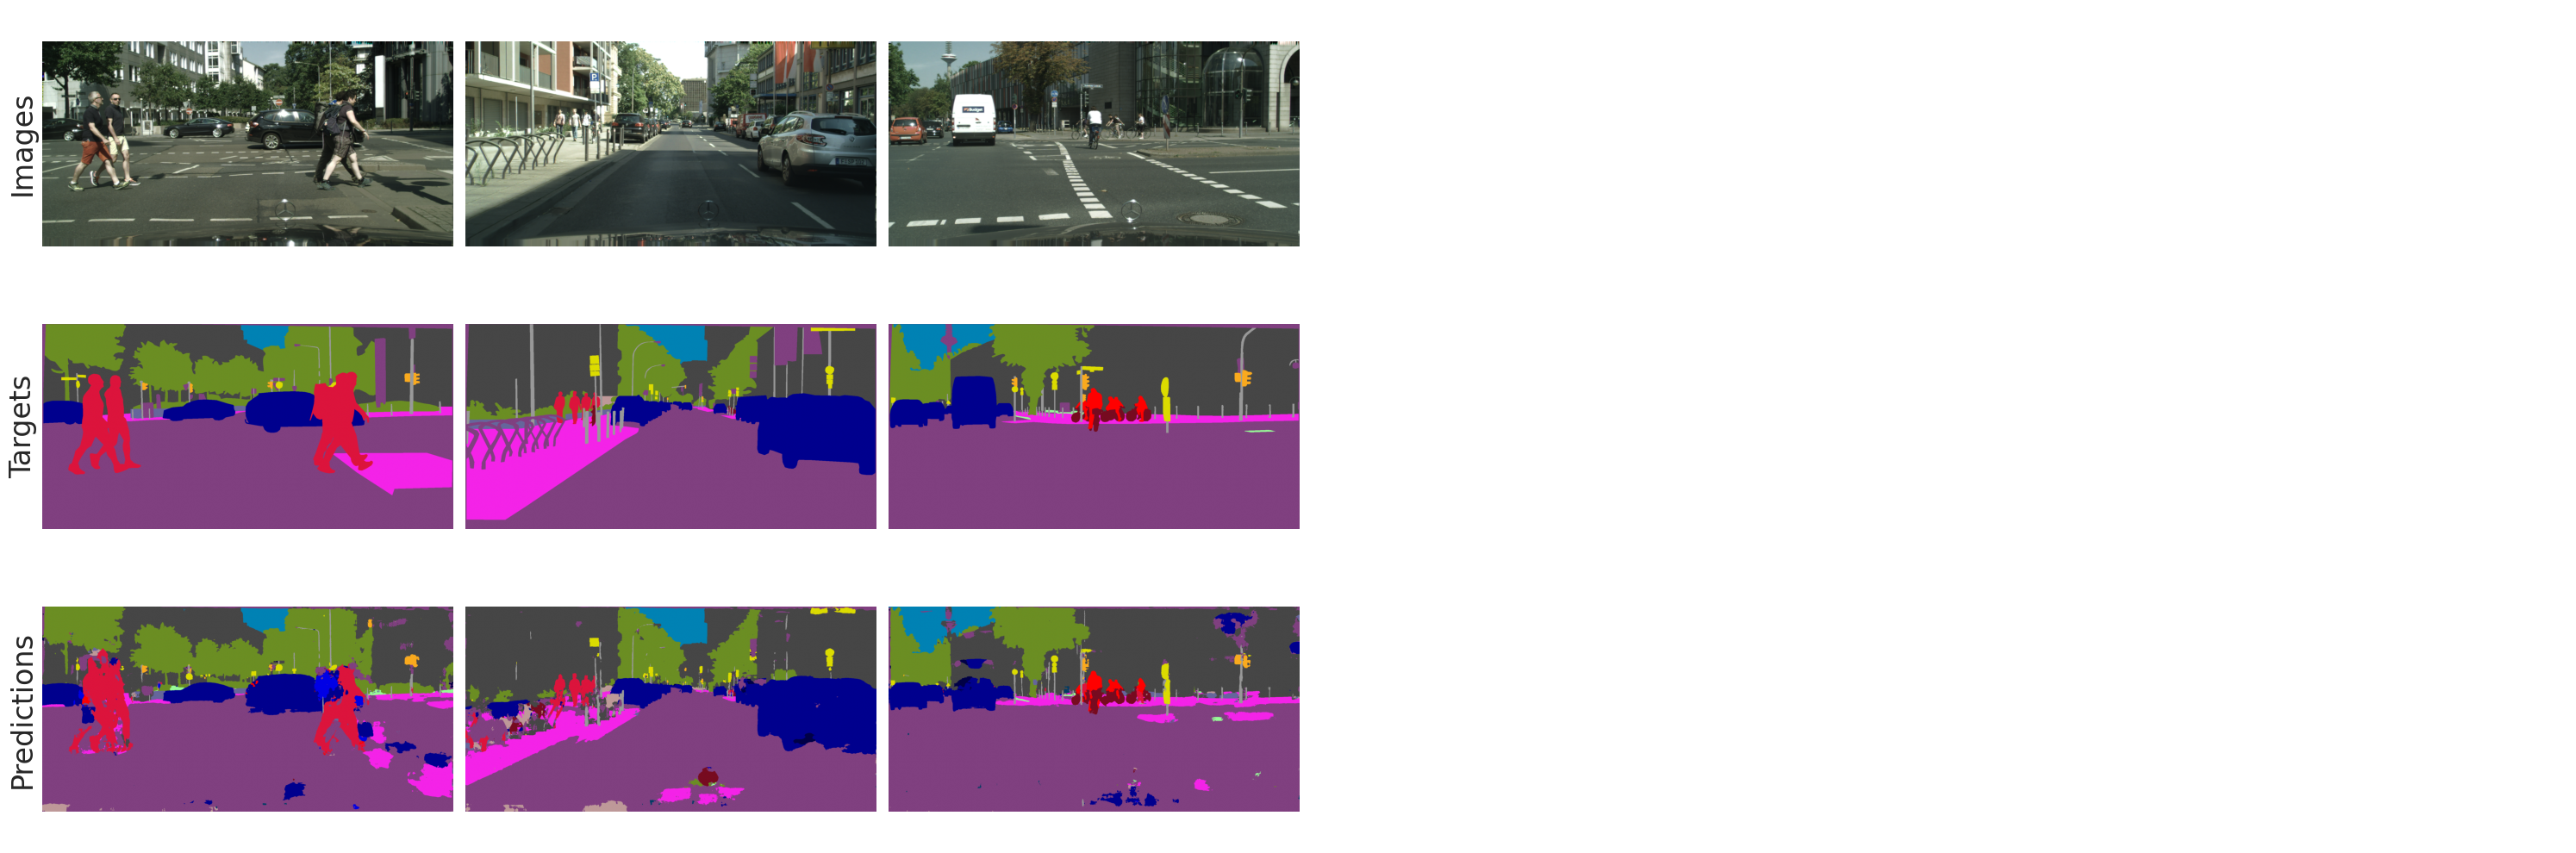

In [14]:
@torch.no_grad()
def add_visualization(model, eval_loader, device="cuda"):
    """ """
    imgs_arr, lbls_arr, preds_arr = [], [], []
    for i, (img, lbl) in enumerate(eval_loader):

        img = img.to(device)
        lbl[lbl == 250] = 0

        outputs = model(img) 
        _, preds = torch.max(outputs, 1) 

        print("preds.shape", preds.shape)
        print("image.shape", img.shape)
        print("label.shape", lbl.shape)
        
        imgs_arr.append(img.cpu())
        lbls_arr.append(lbl.cpu())
        preds_arr.append(preds.cpu())
        break
    imgs_arr = torch.cat(imgs_arr, dim=0)
    lbls_arr = torch.cat(lbls_arr, dim=0)
    preds_arr = preds

    fig, ax = vis.qualitative_evaluation(imgs_arr, lbls_arr, preds_arr)
    #writer.add_figure("Qualitative Eval", fig, global_step=epoch)

    return

add_visualization(model, val_loader, device="cuda")

/tmp/ipykernel_595532/3060915335.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 3, figsize=(20, 10))


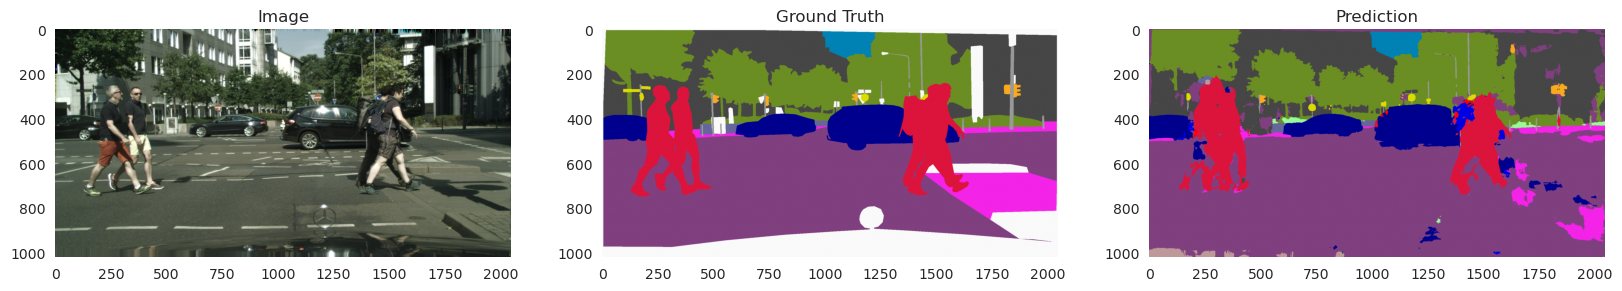

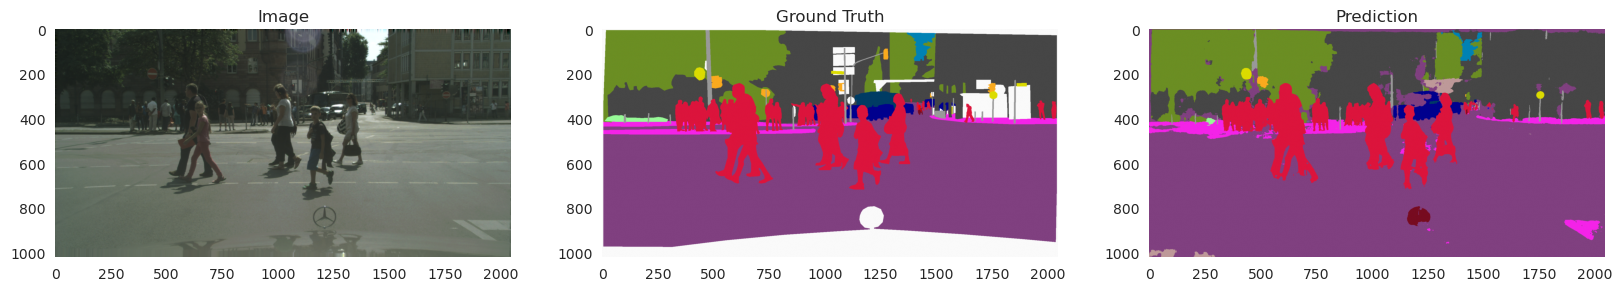

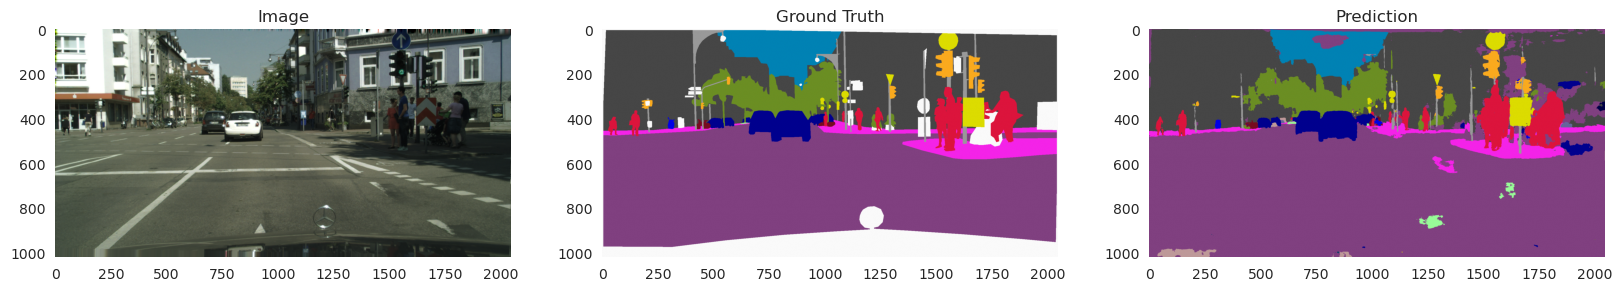

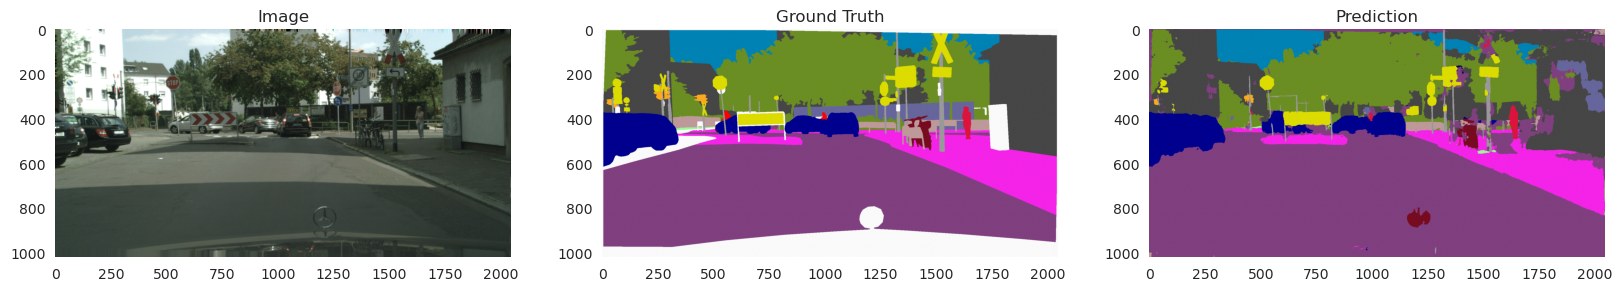

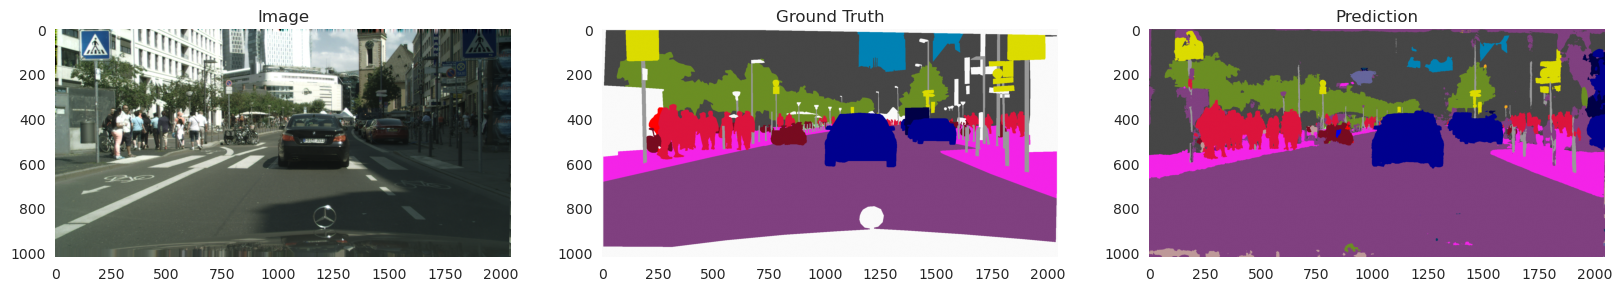

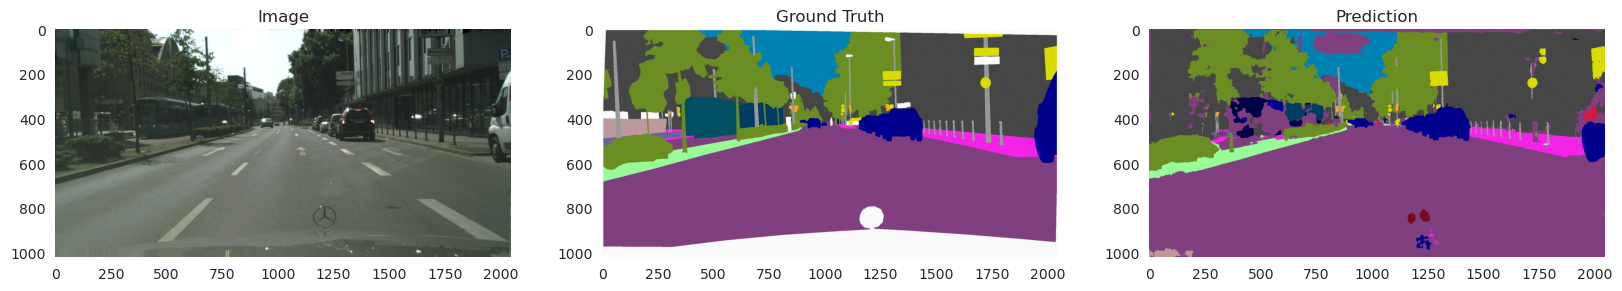

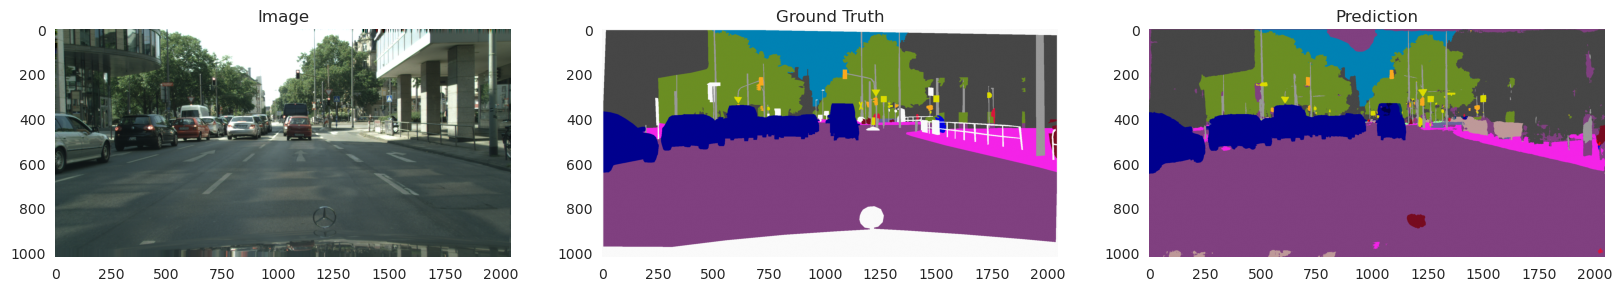

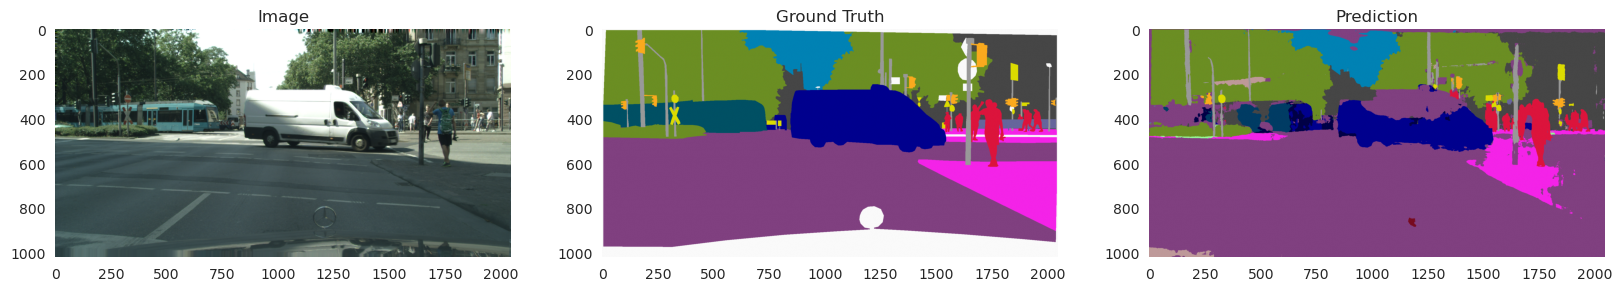

In [15]:
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        images = images.cpu() * std + mean
        if True:
            decoded_pred = val_ds.decode_segmap(preds[0].cpu().numpy())
            decoded_label = val_ds.decode_segmap(labels[0][0].cpu().numpy())
            decoded_img = images[0].cpu().permute(1, 2, 0).numpy()

            
            fig, ax = plt.subplots(1, 3, figsize=(20, 10))
            ax[0].imshow(decoded_img)
            ax[1].imshow(decoded_label)
            ax[2].imshow(decoded_pred)
            # add titles
            ax[0].set_title("Image")
            ax[1].set_title("Ground Truth")
            ax[2].set_title("Prediction")